In [ ]:
%matplotlib inline


# Straight line Hough transform

The Hough transform in its simplest form is a method to detect straight lines
[1]_.

In the following example, we construct an image with a line intersection. We
then use the `Hough transform  <https://en.wikipedia.org/wiki/Hough_transform>`__.
to explore a parameter space for straight lines that may run through the image.

## Algorithm overview

Usually, lines are parameterised as $y = mx + c$, with a gradient
$m$ and y-intercept `c`. However, this would mean that $m$ goes to
infinity for vertical lines. Instead, we therefore construct a segment
perpendicular to the line, leading to the origin. The line is represented by
the length of that segment, $r$, and the angle it makes with the x-axis,
$\theta$.

The Hough transform constructs a histogram array representing the parameter
space (i.e., an $M \times N$ matrix, for $M$ different values of
the radius and $N$ different values of $\theta$).  For each
parameter combination, $r$ and $\theta$, we then find the number
of non-zero pixels in the input image that would fall close to the
corresponding line, and increment the array at position $(r, \theta)$
appropriately.

We can think of each non-zero pixel "voting" for potential line candidates. The
local maxima in the resulting histogram indicates the parameters of the most
probable lines. In our example, the maxima occur at 45 and 135 degrees,
corresponding to the normal vector angles of each line.

Another approach is the Progressive Probabilistic Hough Transform [2]_. It is
based on the assumption that using a random subset of voting points give a good
approximation to the actual result, and that lines can be extracted during the
voting process by walking along connected components. This returns the
beginning and end of each line segment, which is useful.

The function `probabilistic_hough` has three parameters: a general threshold
that is applied to the Hough accumulator, a minimum line length and the line
gap that influences line merging. In the example below, we find lines longer
than 10 with a gap less than 3 pixels.

## References

.. [1] Duda, R. O. and P. E. Hart, "Use of the Hough Transformation to
       Detect Lines and Curves in Pictures," Comm. ACM, Vol. 15,
       pp. 11-15 (January, 1972)

.. [2] C. Galamhos, J. Matas and J. Kittler,"Progressive probabilistic
       Hough transform for line detection", in IEEE Computer Society
       Conference on Computer Vision and Pattern Recognition, 1999.


### Line Hough Transform



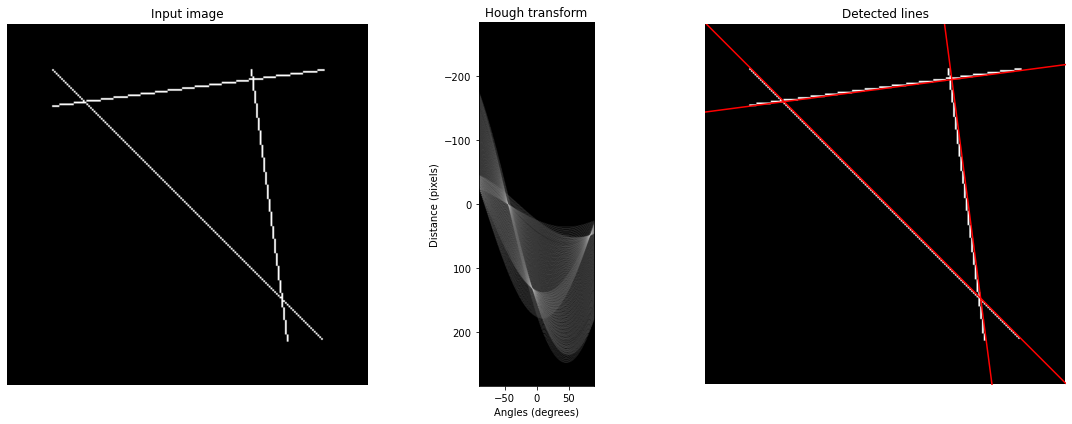

In [1]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx, idx] = 255
image[line(45, 25, 25, 175)] = 255
image[line(25, 135, 175, 155)] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

### Probabilistic Hough Transform



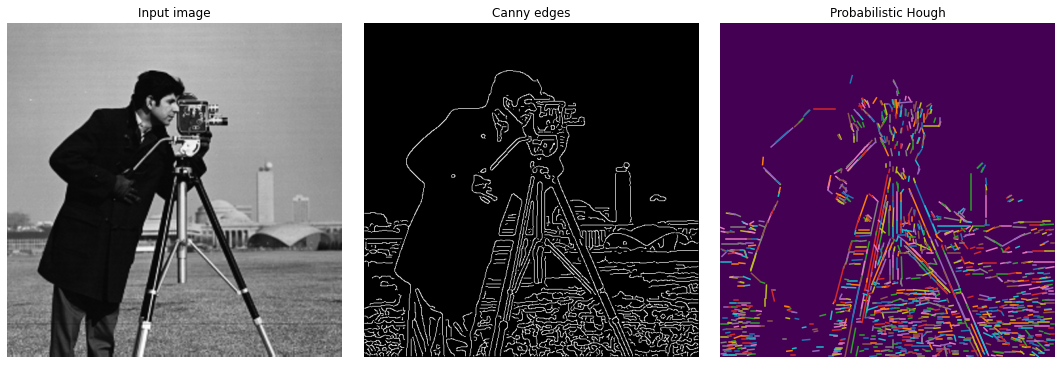

In [2]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()